# Tutorial on GraphNN

We try to build a GraphNN that recognize if an image contains a rectangle or a circle, representing the image as a point cloud.

This tutorial is based on this PointCloud GNN tutorial:
https://colab.research.google.com/drive/1D45E5bUK3gQ40YpZo65ozs7hg5l-eo_U

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html


2.6.0+cu124
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch    #we use pytorch
import torch_geometric  #and the "geometric" package to help handling GNNs
from torch_cluster import knn_graph #utility to search for  nearest neighbor on a graph
import networkx as nx #tool to draw graphs
import matplotlib.pyplot as plt

#some standard imports
from  array  import array
import numpy as np
from sklearn.model_selection import train_test_split
#import h5py

N=2000  #number of samples to generate
filled=False  #if true the point cloud fills the figure, if false the points are on the border
if filled:
  S=200   #number of nodes per graph
else :
  S=20   #number of nodes per graph


#generate rectanlge point cloud
if not filled : #border only
  xy=np.random.randint(0,2, size=S*N) #vertical vs horizontal 0 or 1
  side=np.random.randint(0,2, size=S*N) # left vs right  or top vs bottom 0 or 1
  a=np.random.uniform(0,1, size=S*N)*xy +side*(1-xy) # (a,b) are the points in [0,1]x[0,1] coordinate system of the rectangle
  b=np.random.uniform(0,1, size=S*N)*(1-xy)+side*xy  # in this case only a or b are [0,1] distributed, the other is just 0 or 1
else:
  a=np.random.uniform(0,1, size=S*N)  #in this case we fill the full rectangle so we throw randomly both
  b=np.random.uniform(0,1, size=S*N)

#now change the absolute position of the rectangle and its width and height
w=np.repeat(np.random.uniform(3,10, size=N) ,S)
h=np.repeat(np.random.uniform(3,10, size=N) ,S)
px=np.repeat(np.random.uniform(1,90, size=N) ,S)
py=np.repeat(np.random.uniform(1,90, size=N) ,S)

#rectangle X and Y pints, reshaped version with one row corresponding to one graph
rx=(a*w+px).reshape(N,-1)
ry=(b*h+py).reshape(N,-1)

#features tensor for ML
X_rect=np.stack([rx,ry],axis=2)
#so the size should be (N,S,2) where the 2 is (coordX,coordY)
print(X_rect.shape)

#generate circle
theta = np.random.uniform(0,2*np.pi, S*N)
if filled: #filled = random radius
  radius = np.random.uniform(0,1, S*N) ** 0.5 #sqrt(r) to make it uniform when theta is flat
else: #border only = fixed radius
  radius = np.ones(S*N) #np.random.uniform(0.99,1, S*N) ** 0.5

#scale and decide center of the circle
scale=np.repeat(np.random.uniform(3,10, size=N) ,S)
ox=np.repeat(np.random.uniform(10,90, size=N) ,S)
oy=np.repeat(np.random.uniform(10,90, size=N) ,S)

#circle X and Y points actual position of the points
cx = (radius * np.cos(theta) *scale+ox).reshape(N,-1)
cy = (radius * np.sin(theta) *scale + oy).reshape(N,-1)
#features tensor for ML
X_circ=np.stack([cx,cy],axis=2)
print(X_circ.shape)

#concatenate rect, circls and their trurt zero/one labels
X=np.concatenate([X_rect,X_circ])
y=np.concatenate([np.zeros(N),np.ones(N)]).reshape((-1,1))

#shuflle and split as train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.5, random_state=1)





(2000, 20, 2)
(2000, 20, 2)


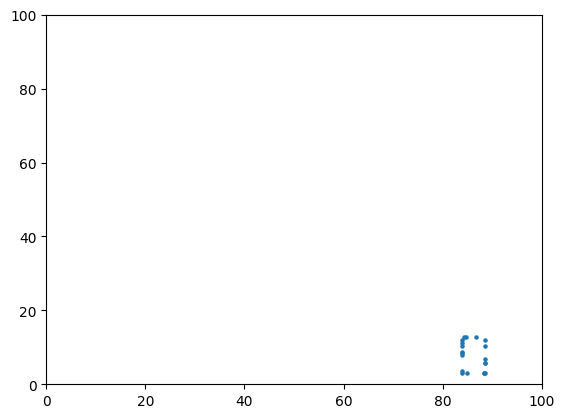

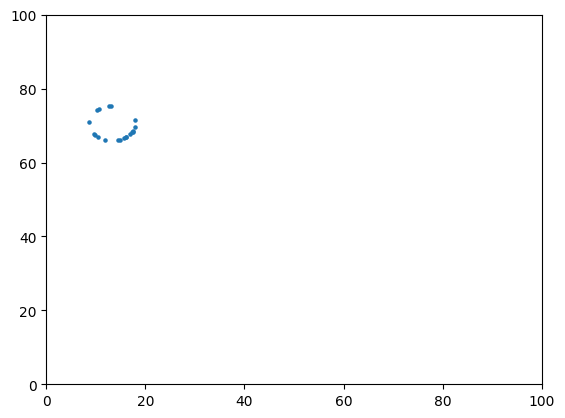

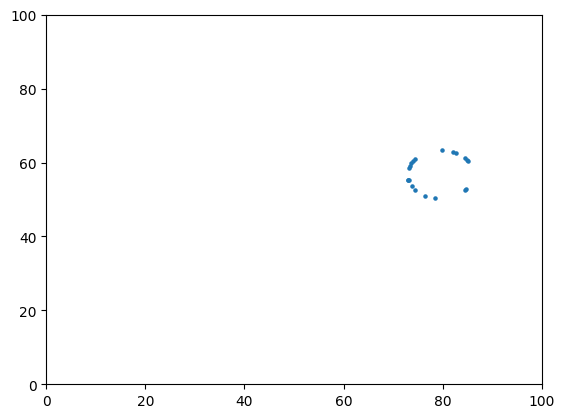

In [ ]:

#let's look at few of them
for j in range(3):
  plt.xlim(0, 100)
  plt.ylim(0, 100)
  plt.scatter(X_train[j,:,0],X_train[j,:,1],s=(1 if filled else 5))
  plt.show()

tensor([[ 6,  1, 13, 10,  2,  8, 11,  0,  4,  9, 12,  3,  6, 13,  0, 12,  2, 13,
          6, 10,  5,  7, 11,  9,  8,  4,  7, 11,  9,  8,  2,  0, 12,  3, 13,  9,
          5,  4, 10, 11,  1, 11,  4,  5,  7,  7, 10, 13,  5,  4, 13,  9,  7,  5,
          4,  4,  8,  5,  1,  7,  3,  2,  6, 13, 10, 10,  9,  7,  3, 12],
        [ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,
          3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,
          7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10,
         10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13]])


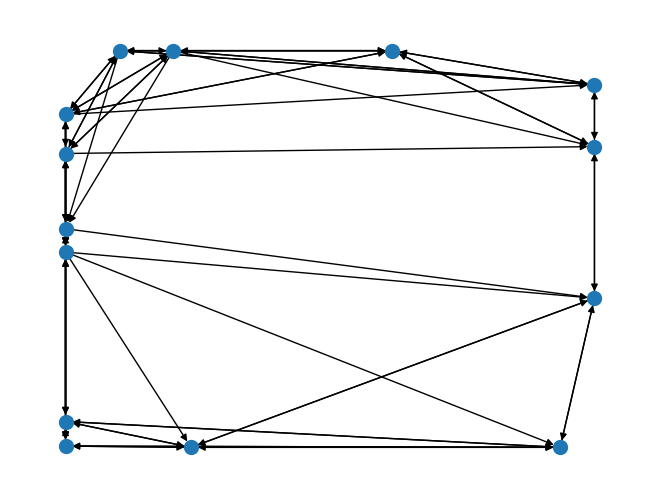

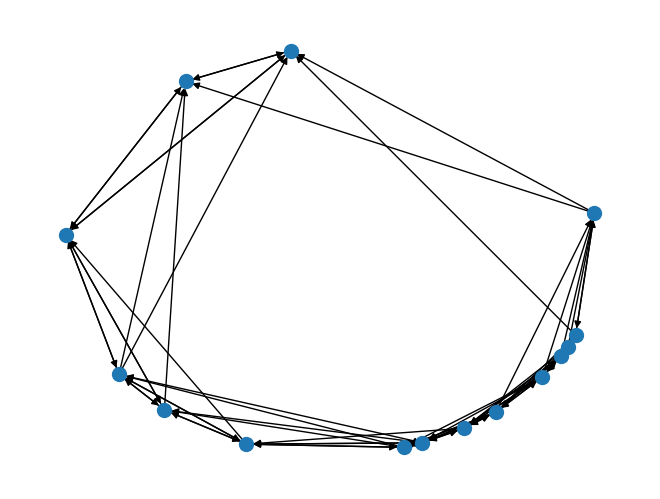

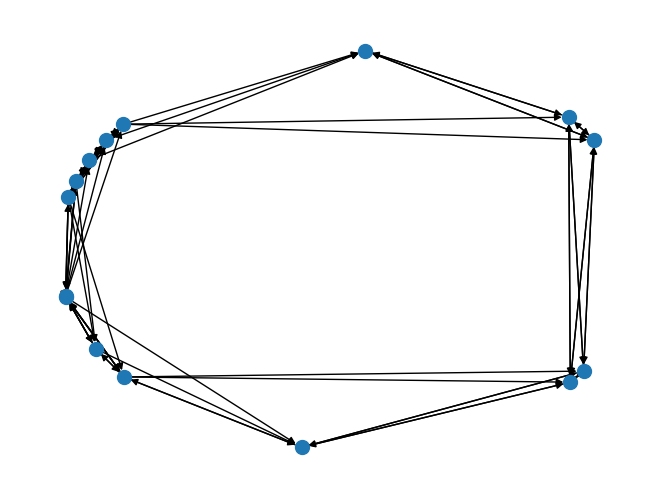

In [ ]:

import random
#Now create a "graph" Data structure
#a list of such "Data" objects is a possible representation of a dataset
#(more complex behaviour can be obtained inheriting from Dataset class)
#we can randomly cut our initially generated point cloud so that our
#dataset is made of graphs with different sizes
dataset_train = [torch_geometric.data.Data(x=torch.Tensor(x[:random.randint(S/2,S)]),y=torch.Tensor(y.reshape(1,1))) for x,y in zip(X_train,Y_train)]
dataset_test = [torch_geometric.data.Data(x=torch.Tensor(x[:random.randint(S/2,S)]),y=torch.Tensor(y.reshape(1,1))) for x,y in zip(X_test,Y_test)]

#so far we only have nodes in our graph
#Let's add some connections with knn_graph, for each node we search the xxx nearest neighbors
# and update the "dataset" with the indices of the connections
if filled:
  nNeighbors=15
else:
  nNeighbors=5
for data in dataset_train:
    data.edge_index = knn_graph(data.x, k=nNeighbors)
for data in dataset_test:
    data.edge_index = knn_graph(data.x, k=nNeighbors)

#edge_index tensor contains a list of pairs of nodes to be connected, with indices 0 to S-1
print(dataset_train[0].edge_index)

#let's look at few of them now with connections
for j in range(3):
  data = dataset_train[j]
  g = torch_geometric.utils.to_networkx(data)
  x=data.x
  nx.draw(g,{i:[p[0],p[1]] for i,p in enumerate(x)},node_size=(25 if filled else 100))
  plt.show()


In [ ]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing

#We create a layer that inherits from "MessagePassing" layer and defines what is the "message"
# Our message is a (trainable) MLP made of two dense layers with Relu activation
# The number of nodes in the MLP layers can be defined given some number of input and output channels


class DNNMPLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        #We can use the "max" aggregation
        super().__init__(aggr='max')
        #we create a MLP to build the message
        self.mlp = Sequential(Linear(2*in_channels, out_channels), #2* because we pass to our MLP both the h_i and the h_j-h_i
                              ReLU(),
                              Linear(out_channels, out_channels),
                             # ReLU()
                              )

    def forward(self, h,  edge_index):
        # Start propagating messages.
        accumulated_message= self.propagate(edge_index, h=h)
        return accumulated_message
        #here we just named "h" the learned features on the node
        # this name will be used later in the "message" function

    #based on the name given above we can read here h_i (the aggregating node) and h_j (the neighbor)
    def message(self,  h_j, h_i):
        #our learnable message is the MLP and we pass it the node learned feature (h_i)
        #as well as the difference h_j - h_i (see EdgeConv https://arxiv.org/abs/1801.07829)
        input = torch.cat([ h_i, h_j - h_i], dim=-1)
        return self.mlp(input)


In [ ]:
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool, global_mean_pool


class MessagePassingNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        N_features=20
        torch.manual_seed(12345)
        self.pass1 = DNNMPLayer(2, N_features)  #the first node has 2 input features (position x,y)
        self.pass2 = DNNMPLayer(N_features, N_features)
        self.pass3 = DNNMPLayer(N_features, N_features)
        self.classifier = Linear(N_features, 1)

    def forward(self, data, batch):
        edge_index=data.edge_index
        #input data of each node, in our case only its x,y position
        x=data.x

        h = self.pass1(h=x , edge_index=edge_index)
        h = h.relu()
        h = self.pass2(h=h,edge_index=edge_index)
        h = h.relu()
        h = self.pass3(h=h, edge_index=edge_index)
      #  h = global_mean_pool(h, batch)
      #  h_global = torch.sigmoid(self.classifier(h))

        h = torch.sigmoid(self.classifier(h))
        h_global = global_mean_pool(h, batch)
        return h_global,h


model = MessagePassingNetwork()
print(model)

MessagePassingNetwork(
  (pass1): DNNMPLayer()
  (pass2): DNNMPLayer()
  (pass3): DNNMPLayer()
  (classifier): Linear(in_features=20, out_features=1, bias=True)
)


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 1000})'''))



from torch_geometric.loader import DataLoader
train_loader = DataLoader(dataset_train, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=10)



optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFunc = torch.nn.BCELoss()

def train(model, optimizer, loader):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        out,out_nodes = model(data, data.batch )  # Forward pass.
        loss = lossFunc(out, data.y)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(model, loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    for data in loader:
        pred,pred_nodes = model(data, data.batch)
        loss = lossFunc(pred, data.y)
        total_loss += loss.item() * data.num_graphs
        total_correct += int(( (pred > 0.5)== data.y).sum())
    return total_correct / len(loader.dataset), total_loss / len(train_loader.dataset)

test_losses = []
train_losses = []
for epoch in range(1, 100 ):
    loss = train(model, optimizer, train_loader)
    test_acc,test_loss = test(model, test_loader)
    test_losses.append(test_loss)
    train_losses.append(loss)
    print(f'Epoch: {epoch:02d}, Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')



<IPython.core.display.Javascript object>

Epoch: 01, Train Loss: 0.6393, Test Loss: 0.5823, Test Accuracy: 0.6925
Epoch: 02, Train Loss: 0.5453, Test Loss: 0.5142, Test Accuracy: 0.7495
Epoch: 03, Train Loss: 0.4993, Test Loss: 0.4878, Test Accuracy: 0.7630
Epoch: 04, Train Loss: 0.4772, Test Loss: 0.4734, Test Accuracy: 0.7730
Epoch: 05, Train Loss: 0.4598, Test Loss: 0.4691, Test Accuracy: 0.7755
Epoch: 06, Train Loss: 0.4540, Test Loss: 0.4719, Test Accuracy: 0.7740
Epoch: 07, Train Loss: 0.4408, Test Loss: 0.4495, Test Accuracy: 0.7870
Epoch: 08, Train Loss: 0.4391, Test Loss: 0.4602, Test Accuracy: 0.7730
Epoch: 09, Train Loss: 0.4268, Test Loss: 0.4581, Test Accuracy: 0.7850
Epoch: 10, Train Loss: 0.4196, Test Loss: 0.4437, Test Accuracy: 0.7870
Epoch: 11, Train Loss: 0.4260, Test Loss: 0.4323, Test Accuracy: 0.8010
Epoch: 12, Train Loss: 0.4080, Test Loss: 0.4296, Test Accuracy: 0.7985
Epoch: 13, Train Loss: 0.4004, Test Loss: 0.4295, Test Accuracy: 0.8060
Epoch: 14, Train Loss: 0.3967, Test Loss: 0.4003, Test Accuracy:

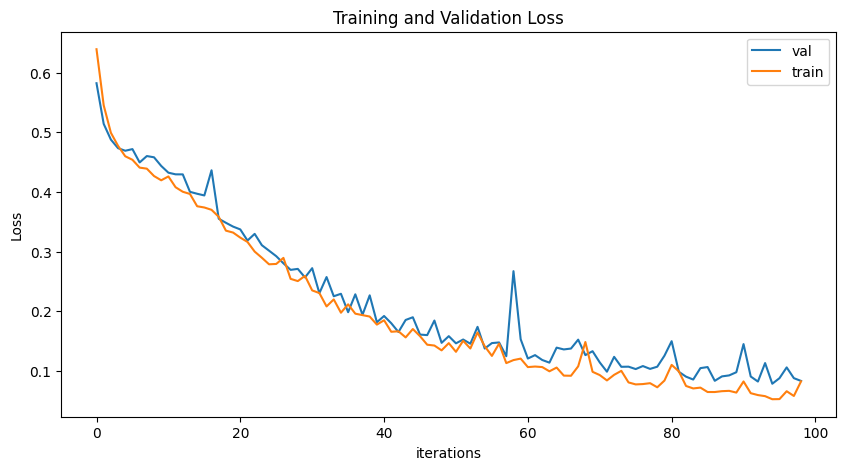

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Assignments:


*   Try to change the complexity of the MP network
*   Try to predict the target (rect vs circle) on each single node, then make a global target by only pooling. Try to visualize (drawing a color scale graph), which points contributed most to the final decision



tensor([[0.6874]], grad_fn=<MeanBackward1>)


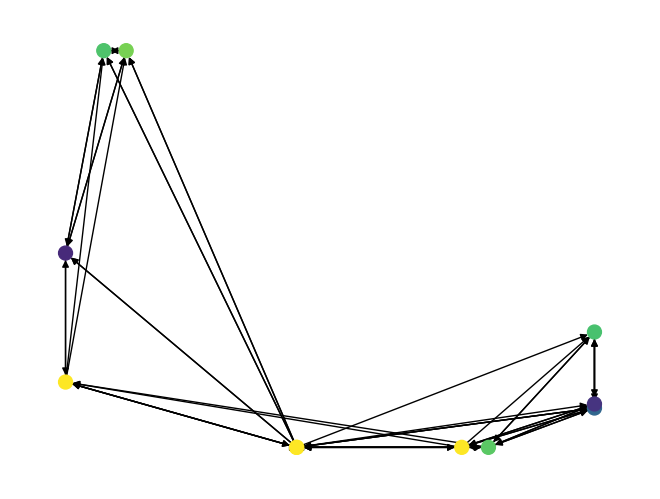

tensor([[0.0211]], grad_fn=<MeanBackward1>)


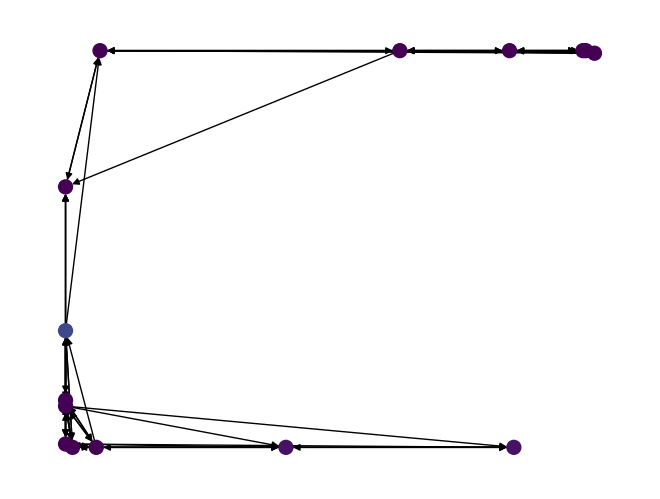

tensor([[0.1108]], grad_fn=<MeanBackward1>)


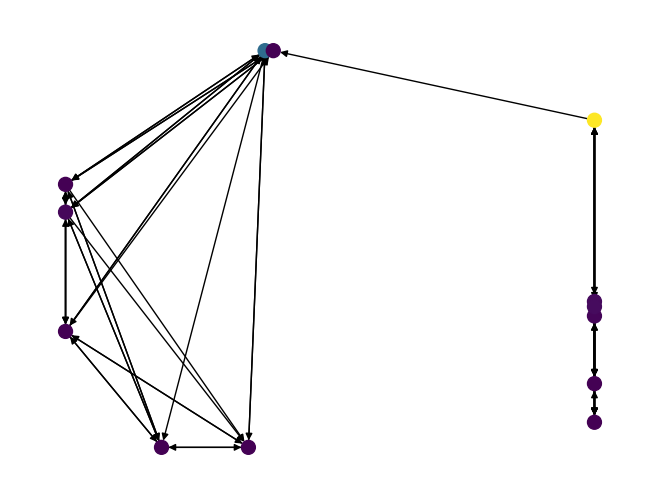

tensor([[1.]], grad_fn=<MeanBackward1>)


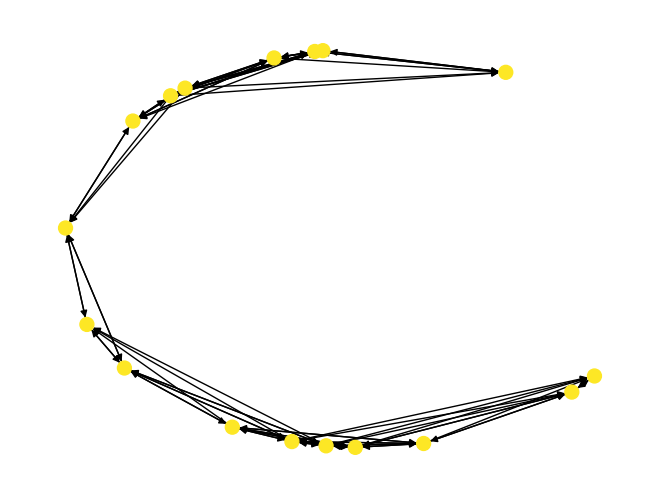

tensor([[0.2424]], grad_fn=<MeanBackward1>)


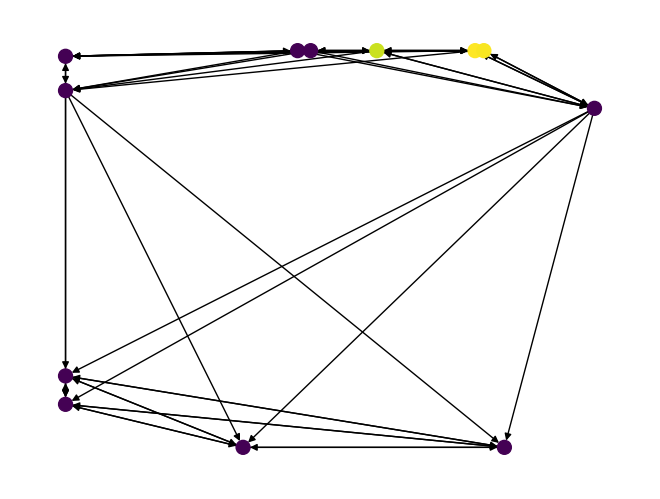

In [ ]:
model.eval()
for i in range(5):
  data = dataset_test[i]
  g = torch_geometric.utils.to_networkx(data)
  x=data.x
  plt.show()
  out,outnodes=model(data,None)
#  print(outnodes)
  print(out)
  nx.draw(g,{i:[p[0],p[1]] for i,p in enumerate(x)},node_color=outnodes.detach().numpy(),vmin=0,vmax=1,node_size=(35 if filled else 100))
#  nx.draw(g,{i:[p[0],p[1]] for i,p in enumerate(x)},node_size=(35 if filled else 100))
